In [1]:
import cv2 as cv
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.is_available())

True


In [3]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in C:\Users\asus guest/.cache\torch\hub\intel-isl_MiDaS_master


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\asus guest/.cache\torch\hub\intel-isl_MiDaS_master


In [6]:
from zipfile import ZipFile
import io

def getImageFromZip(zipobj, fname, imreadFlag):
  if fname in zipobj.namelist():
    image_data = zipobj.read(fname)
    image_buffer = io.BytesIO(image_data)
    return cv.imdecode(np.frombuffer(image_buffer.getvalue(), np.uint8), imreadFlag)
  else:
    raise ValueError("Error, given file does not exit")

In [13]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 7CEA-B5BE

 Directory of c:\Users\asus guest\Desktop\Projects\Programming\ENS492\Tests

28.03.2024  19:47    <DIR>          .
28.03.2024  19:47    <DIR>          ..
28.03.2024  19:47         1.368.981 midas_test_3.ipynb
               1 File(s)      1.368.981 bytes
               2 Dir(s)  185.941.176.320 bytes free


In [7]:
path = "c:\\Users\\asus guest\\Desktop\\Projects\\Programming\\ENS492\\Dataset\\"
zip_file = path+"rgbd-scene-time-lapses.zip"
zipf = ZipFile(zip_file, 'r')

In [8]:
zipf.namelist()[:20]

['chess/TestSplit.txt',
 'chess/TrainSplit.txt',
 'chess/chess.png',
 'chess/seq-01/frame-000000.color.png',
 'chess/seq-01/frame-000000.depth.png',
 'chess/seq-01/frame-000000.pose.txt',
 'chess/seq-01/frame-000001.color.png',
 'chess/seq-01/frame-000001.depth.png',
 'chess/seq-01/frame-000001.pose.txt',
 'chess/seq-01/frame-000002.color.png',
 'chess/seq-01/frame-000002.depth.png',
 'chess/seq-01/frame-000002.pose.txt',
 'chess/seq-01/frame-000003.color.png',
 'chess/seq-01/frame-000003.depth.png',
 'chess/seq-01/frame-000003.pose.txt',
 'chess/seq-01/frame-000004.color.png',
 'chess/seq-01/frame-000004.depth.png',
 'chess/seq-01/frame-000004.pose.txt',
 'chess/seq-01/frame-000005.color.png',
 'chess/seq-01/frame-000005.depth.png']

In [9]:
for name in zipf.namelist():
    if name.find("fire") >= 0:
        print(name)

fire/fire/TestSplit.txt
fire/fire/TrainSplit.txt
fire/fire/fire.png
fire/fire/seq-01.zip
fire/fire/seq-01/seq-01/Thumbs.db
fire/fire/seq-01/seq-01/frame-000000.color.png
fire/fire/seq-01/seq-01/frame-000000.depth.png
fire/fire/seq-01/seq-01/frame-000000.pose.txt
fire/fire/seq-01/seq-01/frame-000001.color.png
fire/fire/seq-01/seq-01/frame-000001.depth.png
fire/fire/seq-01/seq-01/frame-000001.pose.txt
fire/fire/seq-01/seq-01/frame-000002.color.png
fire/fire/seq-01/seq-01/frame-000002.depth.png
fire/fire/seq-01/seq-01/frame-000002.pose.txt
fire/fire/seq-01/seq-01/frame-000003.color.png
fire/fire/seq-01/seq-01/frame-000003.depth.png
fire/fire/seq-01/seq-01/frame-000003.pose.txt
fire/fire/seq-01/seq-01/frame-000004.color.png
fire/fire/seq-01/seq-01/frame-000004.depth.png
fire/fire/seq-01/seq-01/frame-000004.pose.txt
fire/fire/seq-01/seq-01/frame-000005.color.png
fire/fire/seq-01/seq-01/frame-000005.depth.png
fire/fire/seq-01/seq-01/frame-000005.pose.txt
fire/fire/seq-01/seq-01/frame-000006.

In [10]:
dimg = [getImageFromZip(zipf, f'chess/seq-01/frame-000{i}00.depth.png', cv.IMREAD_ANYDEPTH) for i in range(10)]
cimg = [getImageFromZip(zipf, f'chess/seq-01/frame-000{i}00.color.png', cv.IMREAD_COLOR) for i in range(10)]

In [11]:
def predMidas(img):
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  input_batch = transform(img).to(device)
  with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
  return prediction.cpu().numpy()

In [12]:
pimg = [predMidas(cimg[i]) for i in range(10)]

c:\ProgramData\anaconda3\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


In [13]:
k = predMidas(cimg[0])

In [14]:
def fitScale8(depth, pred):
  # Read the two images
  imagex = pred
  imagey = depth
  # Convert the 8-bit image to 16-bit
  imagex_16bit = imagex.astype(np.int16)
  # Flatten the images
  flat_imagex = imagex_16bit.flatten()
  flat_imagey = imagey.flatten()
  # Concatenate the arrays to create a 2D array
  concatenated_array = np.stack((flat_imagey, flat_imagex), axis=1)
  # Filter out pairs containing 0 in the first element
  filtered_array = concatenated_array[concatenated_array[:, 0] != 0]
  # Perform linear regression
  coefficients = np.polyfit(filtered_array[:,1], filtered_array[:,0], 1)
  # Get the slope and intercept of the linear function
  slope, intercept = coefficients
  # Predict the values of image2 based on image1 using the linear function
  predicted_image = slope * filtered_array[:,1] + intercept
  # Calculate the error between the predicted values and the actual values
  error = np.mean((predicted_image - filtered_array[:,0]) ** 2) ** 0.5
  return (slope, intercept, error)

In [15]:
def fitScale(depth, pred):
    # Read the two images
    imagex = pred
    imagey = depth
    
    # Convert the 8-bit image to 16-bit
    imagex_16bit = imagex.astype(np.uint16)
    
    # Flatten the images
    flat_imagex = imagex_16bit.flatten()
    flat_imagey = imagey.flatten()
    
    # Concatenate the arrays to create a 2D array
    concatenated_array = np.stack((flat_imagey, flat_imagex), axis=1)
    
    # Filter out pairs containing 0 in the first element
    filtered_array = concatenated_array[concatenated_array[:, 0] < (1<<13)]
    
    # Perform linear regression
    coefficients = np.polyfit(filtered_array[:, 1], filtered_array[:, 0], 1)
    
    # Get the slope and intercept of the linear function
    slope, intercept = coefficients
    
    # Predict the values of image2 based on image1 using the linear function
    predicted_image = slope * filtered_array[:, 1] + intercept
    
    # Calculate the error between the predicted values and the actual values
    error = np.mean((predicted_image - filtered_array[:, 0]) ** 2) ** 0.5
    
    return (slope, intercept, error)


In [41]:
def fitScaleAndTest(depth, pred):
    # Read the two images
    imagex = pred
    imagey = depth
    
    # Convert the 8-bit image to 16-bit
    imagex_16bit = imagex.astype(np.uint16)
    
    # Flatten the images
    flat_imagex = imagex_16bit.flatten()
    flat_imagey = imagey.flatten()
    
    # Concatenate the arrays to create a 2D array
    concatenated_array = np.stack((flat_imagey, flat_imagex), axis=1)
    
    # Filter out pairs containing 0 in the first element
    filtered_array = concatenated_array[concatenated_array[:, 0] < (1<<13)]
    
    # Perform linear regression
    coefficients = np.polyfit(filtered_array[:, 1], filtered_array[:, 0], 1)
    
    # Get the slope and intercept of the linear function
    slope, intercept = coefficients

    # Calculate the absolute difference
    dif = np.abs((np.floor((imagex_16bit*slope)+intercept).astype(np.int16))-imagey)
    
    return (slope, intercept, dif)


In [43]:
sc = [fitScaleAndTest(dimg[i], pimg[i]) for i in range(10)]

In [44]:
for i in sc:
  print(i)

(-0.015993055758899397, 2261.9700632442637, array([[2261, 2261, 2261, ..., 2261, 2261, 2261],
       [2261, 2261, 2261, ..., 2261, 2261, 2261],
       [2261, 2261, 2261, ..., 2261, 2261, 2261],
       ...,
       [ 378,  398,  398, ..., 2261, 2261, 2261],
       [ 338,  358,  398, ..., 2261, 2261, 2261],
       [ 358,  358,  398, ..., 2261, 2261, 2261]], dtype=int32))
(-61.016449256470715, 2481.8499932701034, array([[1444, 1444, 1444, ..., 1871, 1871, 1871],
       [1444, 1444, 1444, ..., 1871, 1871, 1871],
       [1444, 1444, 1444, ..., 1871, 1871, 1871],
       ...,
       [ 442,  455,  455, ..., 1566, 1566, 1566],
       [ 455,  455,  455, ..., 1566, 1566, 1566],
       [ 455,  455,  455, ..., 1566, 1566, 1566]], dtype=int32))
(-47.007795679012176, 1553.9422552382237, array([[1400, 1400, 1400, ..., 1365, 1365, 1365],
       [1400, 1400, 1400, ..., 1365, 1365, 1365],
       [1386, 1400, 1400, ..., 1365, 1365, 1365],
       ...,
       [ 331,  331,  331, ...,  519,  519,  519],
      

In [18]:
def mapGtP(ground, s):
  return np.floor(((ground - s[1]) / s[0])).astype(np.int8)
def mapPtG(pred, s):
  #return np.floor(pred.astype(np.int16) * s[0] + s[1]).astype(np.int16)
  return np.abs((np.floor((pimg[1]*sc[1][0])+sc[1][1]).astype(np.int16)))

In [19]:
def makeHist(img):
  hrange = 1<<12
  hbin = 1<<12
  histogram = cv.calcHist(images=[img], channels=[0], mask=None, histSize=[hbin], ranges=[1,hrange])
  return histogram

(array([[480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([    0. ,  6553.5, 13107. , 19660.5, 26214. , 32767.5, 39321. ,
        45874.5, 52428. , 58981.5, 65535. ]),
 <a list of 640 BarContainer objects>)

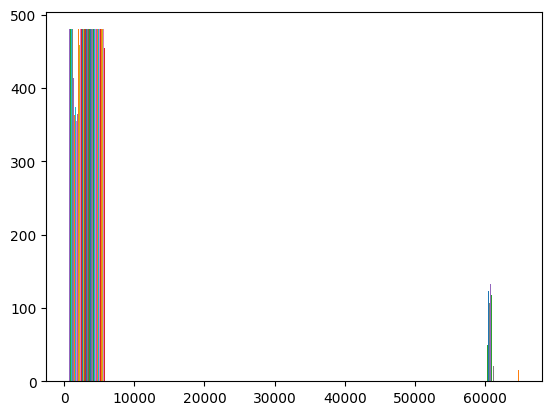

In [45]:
#plt.plot(makeHist(dimg[0]))
plt.hist(dimg[0])

In [21]:
def _pfirst():
  f, axarr = plt.subplots(10,4,figsize=(16,6*10))
  for i in range(10):
    axarr[i,0].imshow(dimg[i])
    axarr[i,1].imshow(mapGtP(dimg[i],sc[i]))
    axarr[i,2].imshow(pimg[i])
    #axarr[i,3].plot(makeHist(np.abs(dimg[i]-pimg[i])))
    axarr[i,3].plot(makeHist(np.abs(mapGtP(dimg[i],sc[i])-pimg[i]))[:128])
    #axarr[i,3].axvline(x=sc[i][2]*(1), color='r', linestyle='--')

In [22]:
sc[1]

(-61.016449256470715, 2481.8499932701034, 793.9384749201953)

(array([[  0.,   0.,  44., ..., 109.,   0.,   0.],
        [  0.,   0.,  46., ..., 110.,   0.,   0.],
        [  0.,   0.,  45., ..., 113.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,  78.,  62., 169.],
        [  0.,   0.,   0., ...,  77.,  64., 169.],
        [  0.,   0.,   0., ...,  77.,  65., 168.]]),
 array([ 834. ,  985.2, 1136.4, 1287.6, 1438.8, 1590. , 1741.2, 1892.4,
        2043.6, 2194.8, 2346. ]),
 <a list of 640 BarContainer objects>)

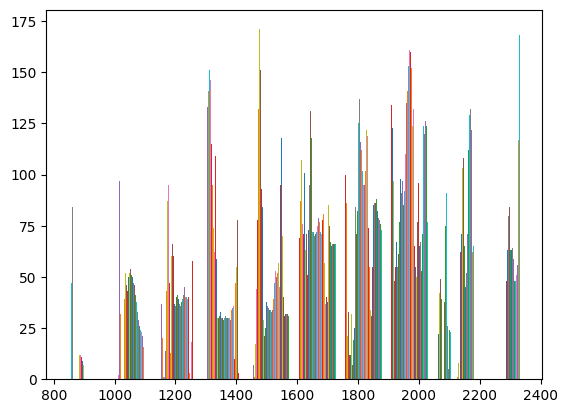

In [27]:
#plt.plot(makeHist(np.floor((pimg[1]*sc[1][0])).astype(np.int8)))
plt.hist(np.floor((pimg[1]*sc[1][0]+sc[1][1])).astype(np.int16))

(array([[480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([    0. ,  6415.2, 12830.4, 19245.6, 25660.8, 32076. , 38491.2,
        44906.4, 51321.6, 57736.8, 64152. ]),
 <a list of 640 BarContainer objects>)

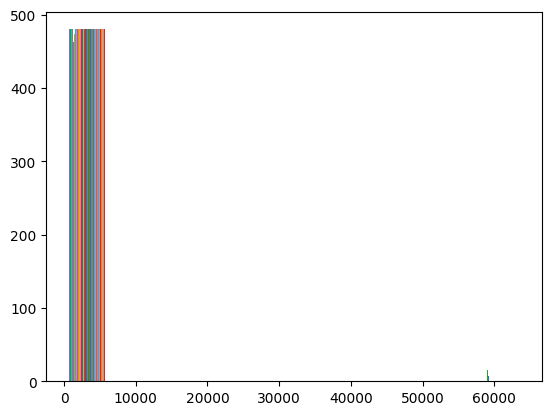

In [46]:
plt.hist(sc[1][2])

(array([[185.,   0.,   0., ...,  45.,  10.,   0.],
        [168.,   0.,   0., ...,  48.,  10.,   0.],
        [166.,   0.,   0., ...,  49.,  13.,   0.],
        ...,
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([   0. ,  409.6,  819.2, 1228.8, 1638.4, 2048. , 2457.6, 2867.2,
        3276.8, 3686.4, 4096. ]),
 <a list of 640 BarContainer objects>)

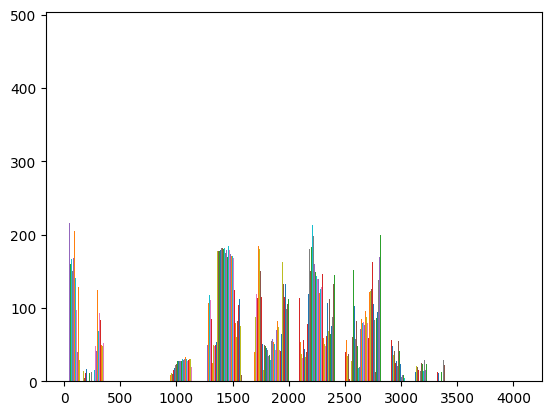

In [28]:
plt.hist(dimg[1], range=(0,4096))

(array([[ 64., 176.,   0., ...,   0.,   0.,   0.],
        [ 61., 193.,   0., ...,   0.,   0.,   0.],
        [ 60., 192.,   1., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([   0. ,  409.6,  819.2, 1228.8, 1638.4, 2048. , 2457.6, 2867.2,
        3276.8, 3686.4, 4096. ]),
 <a list of 640 BarContainer objects>)

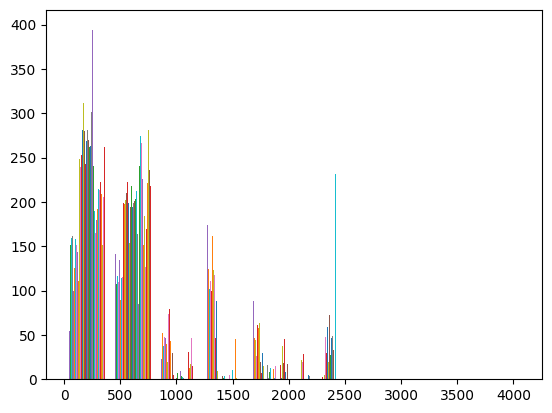

In [29]:
plt.hist(np.abs((np.floor((pimg[1]*sc[1][0])+sc[1][1]).astype(np.int16))-dimg[1]),range=(0,4096))

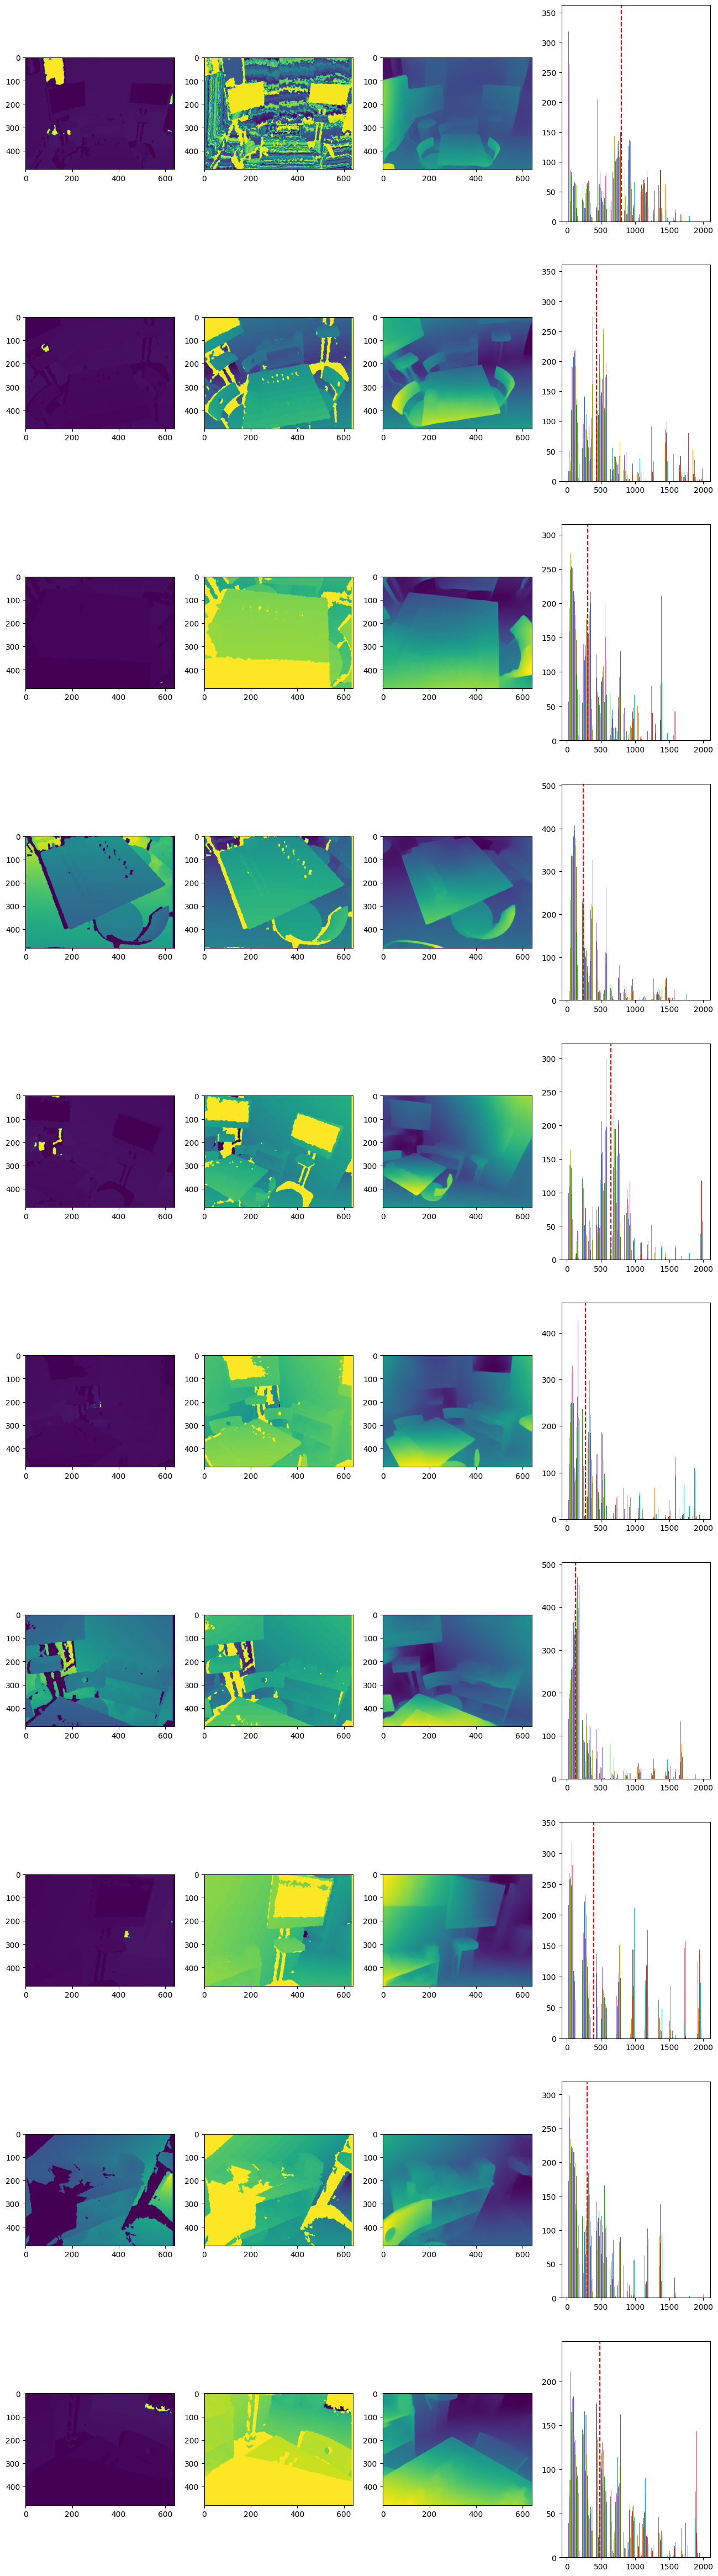

In [48]:
def _p():
  f, axarr = plt.subplots(10,4,figsize=(16,6*10))
  for i in range(10):
    axarr[i,0].imshow(dimg[i])
    axarr[i,1].imshow(mapGtP(dimg[i],sc[i]))
    axarr[i,2].imshow(pimg[i])
    #axarr[i,3].plot(makeHist(np.abs(dimg[i]-pimg[i])))
    #axarr[i,3].plot(makeHist(np.abs(mapPtG(pimg[i],sc[i])-dimg[i]).astype(np.float32)))
    #errabs = np.abs((np.floor((pimg[i].astype(np.int16)*sc[i][0])+sc[i][1]).astype(np.int16))-dimg[i])
    errabs = sc[i][2]
    axarr[i,3].hist(errabs,range=(0,2024))
    axarr[i,3].axvline(x=np.median(errabs), color='r', linestyle='--')
_p()

In [51]:
for i in range(10):
  print(np.mean(sc[i][2])/10,"cm")

297.8022786458333 cm
68.7373662109375 cm
39.817495768229165 cm
33.789489908854165 cm
138.62360188802083 cm
50.1328525390625 cm
31.168187825520835 cm
75.86897526041666 cm
40.408197591145836 cm
84.27041634114583 cm


In [64]:
def print_zip_folders(zip_file):
   for file_info in zip_file.infolist():
        # Split the file path into individual components
        file_path_components = file_info.filename.split('/')
        # Check if the last component is a folder
        if file_info.filename.endswith('/'):
            print(file_info.filename)

print_zip_folders(zipf)

In [ ]:
"""
# Large scale test (params)
rseed = 42
rmin = 0
rmax = 1000
samplenum = 50
target = "chess/seq-01/frame-{:06d}.{}.png"
np.random.seed(rseed)
np.random.uniform(rmin, rmax, samplenum)
"""

In [81]:
# Tests linear hyphothesis on uniformly selected samples
# does not return anything, insteads writes results to given input arguments
def testSet(zipfile, rseed, rmin, rmax, samplenum, target, sampleids, errabs):
    np.random.seed(rseed)
    _s = np.floor(np.random.uniform(rmin, rmax, samplenum)).astype(np.int32)
    for i in range(samplenum):
        sampleids[i] = _s[i]
        print(target.format(sampleids[i], "color"))
        ci = getImageFromZip(zipfile, target.format(sampleids[i], "color"), cv.IMREAD_COLOR)
        di = getImageFromZip(zipfile, target.format(sampleids[i], "depth"), cv.IMREAD_ANYDEPTH)
        pi = predMidas(ci)
        errabs[i] = fitScaleAndTest(di, pi)[2]

In [96]:
_sids = sids
_erra = erra

In [102]:
samplenumber = 50
seeds = (23,58,42,19)
targets = (
    "fire/fire/seq-01/seq-01/frame-{:06d}.{}.png",
    "fire/fire/seq-01/seq-01/frame-{:06d}.{}.png",
    "chess/seq-01/frame-{:06d}.{}.png",
    "chess/seq-02/frame-{:06d}.{}.png",
)
sids = [[None for i in range(samplenumber)] for k in targets]
erra = [[None for i in range(samplenumber)] for k in targets]
for t in range(2,4):
    testSet(zipf, seeds[t], 0, 1000, samplenumber, targets[t], sids[t], erra[t])

chess/seq-01/frame-000374.color.png
chess/seq-01/frame-000950.color.png
chess/seq-01/frame-000731.color.png
chess/seq-01/frame-000598.color.png
chess/seq-01/frame-000156.color.png
chess/seq-01/frame-000155.color.png
chess/seq-01/frame-000058.color.png
chess/seq-01/frame-000866.color.png
chess/seq-01/frame-000601.color.png
chess/seq-01/frame-000708.color.png
chess/seq-01/frame-000020.color.png
chess/seq-01/frame-000969.color.png
chess/seq-01/frame-000832.color.png
chess/seq-01/frame-000212.color.png
chess/seq-01/frame-000181.color.png
chess/seq-01/frame-000183.color.png
chess/seq-01/frame-000304.color.png
chess/seq-01/frame-000524.color.png
chess/seq-01/frame-000431.color.png
chess/seq-01/frame-000291.color.png
chess/seq-01/frame-000611.color.png
chess/seq-01/frame-000139.color.png
chess/seq-01/frame-000292.color.png
chess/seq-01/frame-000366.color.png
chess/seq-01/frame-000456.color.png
chess/seq-01/frame-000785.color.png
chess/seq-01/frame-000199.color.png
chess/seq-01/frame-000514.co

(array([ 8., 10.,  9., 14., 23., 14.,  8.,  9.,  2.,  3.]),
 array([ 77. ,  97.6, 118.2, 138.8, 159.4, 180. , 200.6, 221.2, 241.8,
        262.4, 283. ]),
 <BarContainer object of 10 artists>)

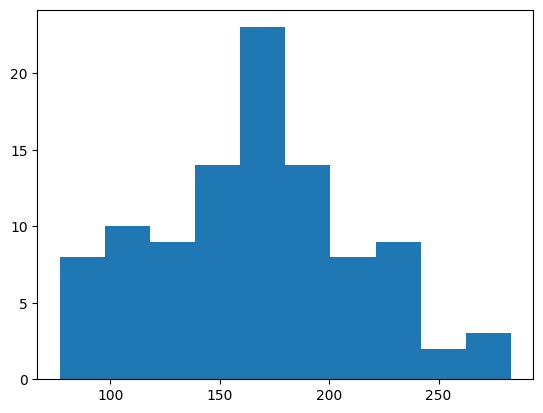

In [99]:
# fire 1,2 seeds: 23,58
emed = list((np.median(i) for i in erra[0])) + list((np.median(i) for i in erra[1]))
plt.hist(emed)

(array([96.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.]),
 array([ 157.77549805,  459.61034342,  761.4451888 , 1063.28003418,
        1365.11487956, 1666.94972493, 1968.78457031, 2270.61941569,
        2572.45426107, 2874.28910645, 3176.12395182]),
 <BarContainer object of 10 artists>)

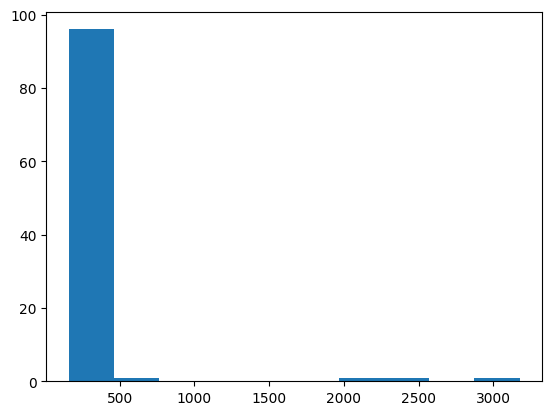

In [100]:
# fire 1,2 seeds: 23,58
emean = list((np.mean(i) for i in erra[0])) + list((np.mean(i) for i in erra[1]))
plt.hist(emean)

(array([ 0.,  0.,  0.,  5., 11., 26., 29., 18.,  4.,  3.]),
 array([  0.,  46.,  92., 138., 184., 230., 276., 322., 368., 414., 460.]),
 <BarContainer object of 10 artists>)

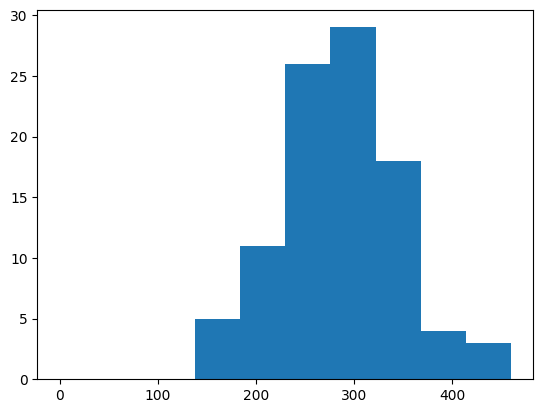

In [101]:
# fire 1,2 focused seeds: 23,58
emean = list((np.mean(i) for i in erra[0])) + list((np.mean(i) for i in erra[1]))
plt.hist(emean,range=(0,460))

(array([ 6.,  4., 21., 39., 11.,  5.,  4.,  4.,  4.,  2.]),
 array([ 65. , 130.3, 195.6, 260.9, 326.2, 391.5, 456.8, 522.1, 587.4,
        652.7, 718. ]),
 <BarContainer object of 10 artists>)

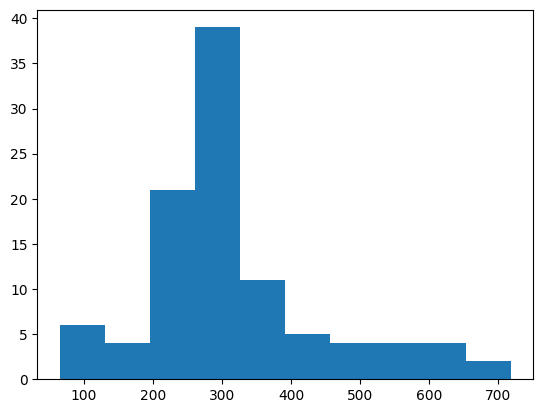

In [103]:
# chess 1,2 seeds: 42, 19
emed = list((np.median(i) for i in erra[2])) + list((np.median(i) for i in erra[3]))
plt.hist(emed)

(array([59., 19.,  5.,  7.,  5.,  2.,  1.,  1.,  0.,  1.]),
 array([ 247.76538737,  518.97691602,  790.18844466, 1061.39997331,
        1332.61150195, 1603.8230306 , 1875.03455924, 2146.24608789,
        2417.45761654, 2688.66914518, 2959.88067383]),
 <BarContainer object of 10 artists>)

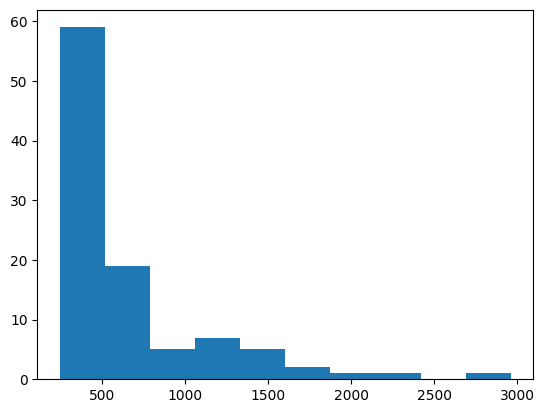

In [104]:
# chess 1,2 seeds: 42, 19
emean = list((np.mean(i) for i in erra[2])) + list((np.mean(i) for i in erra[3]))
plt.hist(emean)

(array([ 0.,  2., 34., 28.,  9.,  7.,  1.,  3.,  5.,  2.]),
 array([   0.,  140.,  280.,  420.,  560.,  700.,  840.,  980., 1120.,
        1260., 1400.]),
 <BarContainer object of 10 artists>)

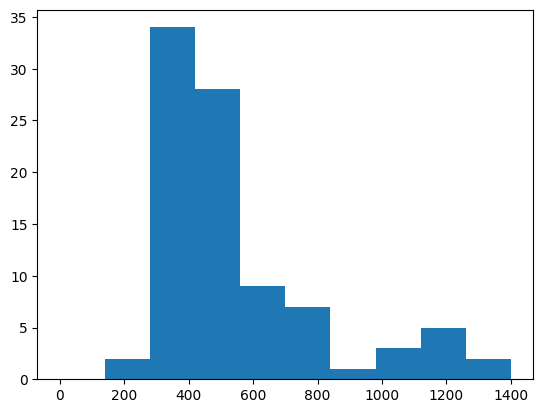

In [105]:
# chess 1,2 seeds: 42, 19
emean = list((np.mean(i) for i in erra[2])) + list((np.mean(i) for i in erra[3]))
plt.hist(emean,range=(0,1400))